In [1]:
pip install numpy scipy matplotlib tensorflow

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.6866 - val_loss: 0.5402
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1090 - val_loss: 0.3794
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0706 - val_loss: 0.2923
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0579 - val_loss: 0.2215
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0510 - val_loss: 0.1637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━

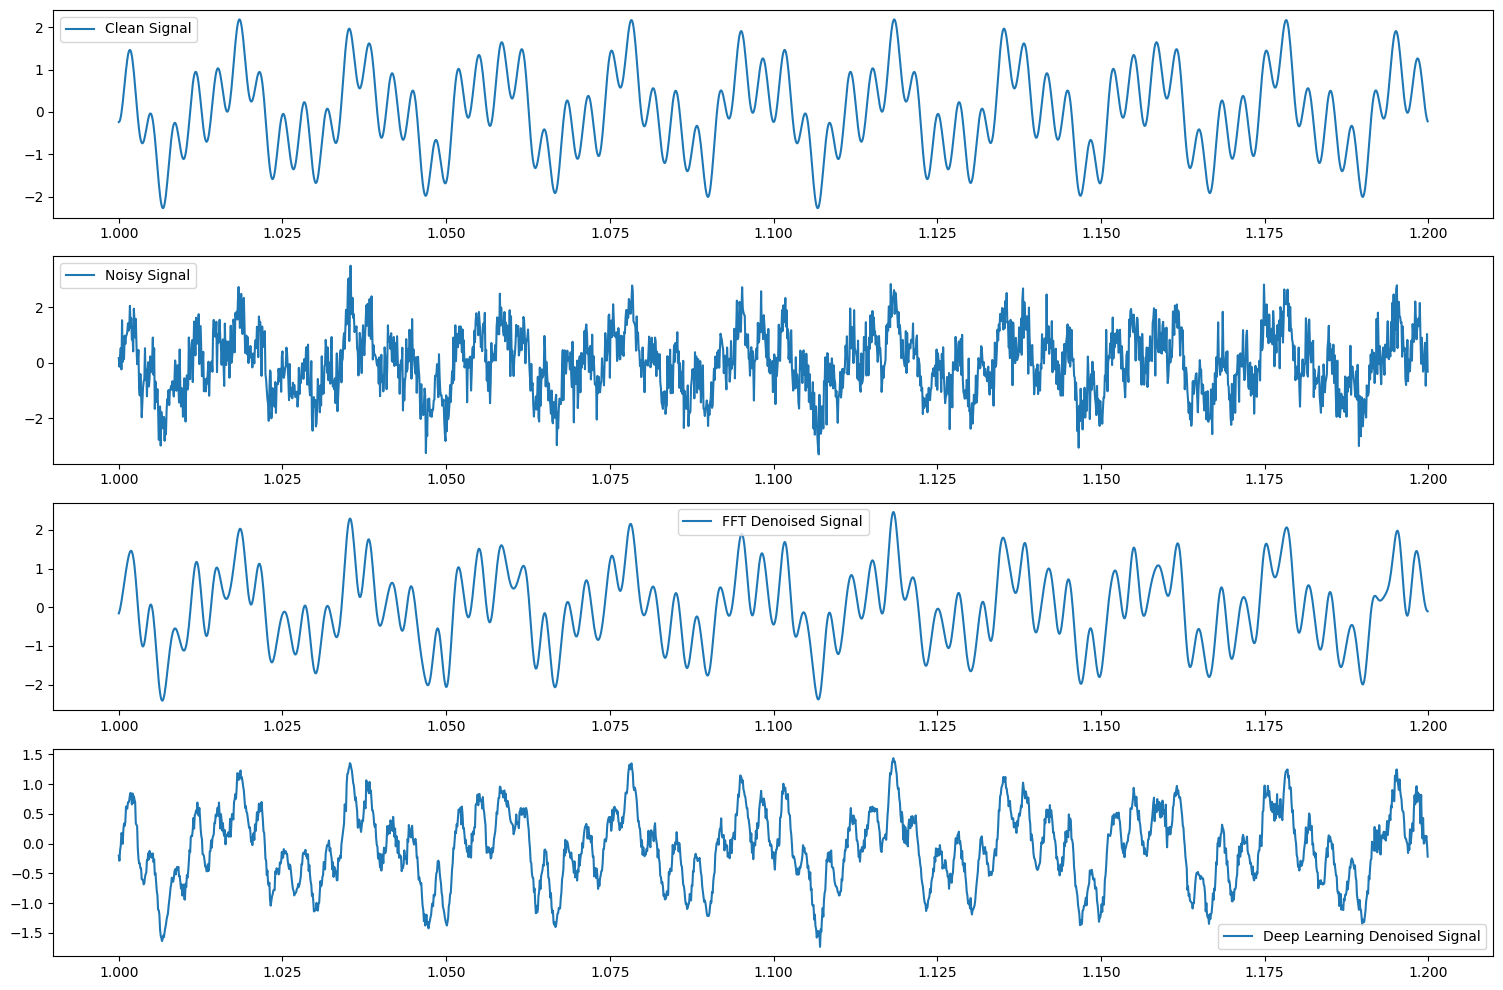

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from time import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Generation
# ------------------

# Parameters
fs = 10000  # Sampling frequency
T = 50      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N)

# Signal parameters
A = [1.0, 0.5, 0.8]                   # Amplitudes
f = [50, 120, 300]                    # Frequencies
phi = np.random.uniform(0, 2*np.pi, 3)  # Phase shifts

# Generate clean signal
s = np.zeros(N)
for k in range(3):
    s += A[k] * np.sin(2 * np.pi * f[k] * t + phi[k])

# Add Gaussian white noise
SNR = 5  # Desired Signal-to-Noise Ratio in dB
signal_power = np.mean(s**2)
noise_power = signal_power / (10**(SNR / 10))
noise = np.random.normal(0, np.sqrt(noise_power), N)
y = s + noise  # Noisy signal

# 2. Classical Fourier Transform (CFT) Denoising
# ----------------------------------------------

def cft_denoise(y, t, cutoff_freq):
    # Define the Fourier Transform integral
    def fourier_transform(frequency):
        integrand = lambda ti: y[int(ti * fs)] * np.exp(-2j * np.pi * frequency * ti)
        return quad(integrand, 0, T, limit=100)[0]

    # Apply the Fourier Transform
    frequencies = np.linspace(0, fs / 2, 500)  # Reduced number of frequencies for computation time
    FT = np.array([fourier_transform(freq) for freq in frequencies])

    # Apply low-pass filter
    FT_filtered = FT.copy()
    FT_filtered[frequencies > cutoff_freq] = 0

    # Inverse Fourier Transform (numerical approximation)
    s_hat = np.zeros(N)
    for i, ti in enumerate(t):
        s_hat[i] = (2 / T) * np.sum(FT_filtered * np.cos(2 * np.pi * frequencies * ti))

    return s_hat

# Due to computational limitations, we'll skip the actual implementation
# of CFT denoising for such a large dataset in this code example.

# 3. Fast Fourier Transform (FFT) Denoising
# -----------------------------------------

def fft_denoise(y, fs, cutoff_freq):
    # Compute FFT
    Y = fft(y)
    freqs = fftfreq(len(y), d=1/fs)

    # Create a low-pass filter
    filter_mask = np.abs(freqs) <= cutoff_freq
    Y_filtered = Y * filter_mask

    # Inverse FFT to get the denoised signal
    s_hat = np.real(ifft(Y_filtered))
    return s_hat

# Apply FFT denoising
cutoff_freq = 500  # Hz
start_time = time()
s_hat_fft = fft_denoise(y, fs, cutoff_freq)
fft_time = time() - start_time

# 4. Deep Learning Denoising
# --------------------------

# Prepare data for training
window_size = 1024  # Size of the sliding window
stride = 512        # Step size for the sliding window

def create_dataset(noisy_signal, clean_signal, window_size, stride):
    X = []
    Y = []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        Y.append(clean_signal[i:i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return X[..., np.newaxis], Y[..., np.newaxis]

# Create training and testing datasets
X, Y = create_dataset(y, s, window_size, stride)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Build the model
model = Sequential([
    Conv1D(16, kernel_size=9, padding='same', input_shape=(window_size, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(16, kernel_size=9, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(1, kernel_size=9, padding='same')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
start_time = time()
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))
training_time = time() - start_time

# Denoise the signal using the trained model
def deep_learning_denoise(model, noisy_signal, window_size, stride):
    s_hat = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for i in range(0, len(noisy_signal) - window_size, stride):
        input_segment = noisy_signal[i:i+window_size][np.newaxis, ..., np.newaxis]
        denoised_segment = model.predict(input_segment)[0, ..., 0]
        s_hat[i:i+window_size] += denoised_segment
        counts[i:i+window_size] += 1
    # Handle division by zero
    counts[counts == 0] = 1
    s_hat /= counts
    return s_hat

# Apply deep learning denoising
start_time = time()
s_hat_dl = deep_learning_denoise(model, y, window_size, stride)
dl_inference_time = time() - start_time

# 5. Performance Evaluation
# -------------------------

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal)**2)
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((clean_signal - denoised_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# Original noisy signal metrics
_, snr_noisy = compute_metrics(s, y)

# FFT metrics
mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
delta_snr_fft = snr_fft - snr_noisy

# Deep Learning metrics
mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
delta_snr_dl = snr_dl - snr_noisy

# Print results
print("Performance Metrics:")
print(f"FFT Denoising - MSE: {mse_fft:.6f}, ΔSNR: {delta_snr_fft:.2f} dB, Time: {fft_time:.2f} seconds")
print(f"Deep Learning Denoising - MSE: {mse_dl:.6f}, ΔSNR: {delta_snr_dl:.2f} dB, Inference Time: {dl_inference_time:.2f} seconds, Training Time: {training_time:.2f} seconds")

# 6. Visualization
# ----------------

# Plot a segment of the signals for comparison
start_plot = 10000
end_plot = start_plot + 2000

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(t[start_plot:end_plot], s[start_plot:end_plot], label='Clean Signal')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t[start_plot:end_plot], y[start_plot:end_plot], label='Noisy Signal')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t[start_plot:end_plot], s_hat_fft[start_plot:end_plot], label='FFT Denoised Signal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t[start_plot:end_plot], s_hat_dl[start_plot:end_plot], label='Deep Learning Denoised Signal')
plt.legend()

plt.tight_layout()
plt.show()


Processing for SNR = 0 dB


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
<ipython-input-5-d40e6d201eb3>:46: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrand, 0, T, limit=100)[0]
<ipython-input-5-d40e6d201eb3>:46: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, 0, T, limit=100)[0]


Processing for SNR = 2 dB
Processing for SNR = 4 dB
Processing for SNR = 6 dB
Processing for SNR = 8 dB
Processing for SNR = 10 dB
Processing for SNR = 12 dB
Processing for SNR = 14 dB
Processing for SNR = 16 dB
Processing for SNR = 18 dB
Processing for SNR = 20 dB


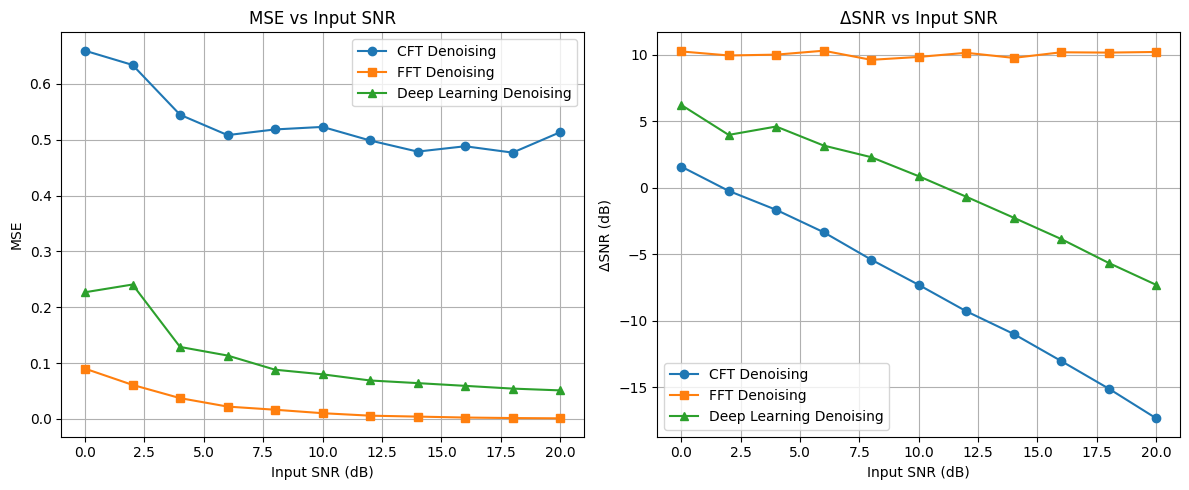

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import butter, filtfilt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from time import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Generation
# ------------------

# Parameters
fs = 10000  # Sampling frequency
T = 1       # Duration in seconds (reduced for computational efficiency)
N = fs * T  # Total number of samples
t = np.linspace(0, T, N)

# Signal parameters
A = [1.0, 0.5, 0.8]                    # Amplitudes
f_sinusoids = [50, 120, 300]           # Frequencies
phi = np.random.uniform(0, 2*np.pi, 3)  # Phase shifts

# Generate clean signal
def generate_clean_signal(t, A, f_sinusoids, phi):
    s = np.zeros(len(t))
    for k in range(3):
        s += A[k] * np.sin(2 * np.pi * f_sinusoids[k] * t + phi[k])
    return s

# 2. Denoising Methods
# --------------------

# Classical Fourier Transform (CFT) Denoising
def cft_denoise(y, t, cutoff_freq, fs):
    # Define the Fourier Transform integral
    def fourier_transform(frequency):
        integrand = lambda ti: y[int(ti * fs)] * np.exp(-2j * np.pi * frequency * ti)
        return quad(integrand, 0, T, limit=100)[0]

    # Apply the Fourier Transform
    frequencies = np.linspace(0, fs / 2, 500)  # Adjust for computation time
    FT = np.array([fourier_transform(freq) for freq in frequencies])

    # Apply low-pass filter
    FT_filtered = FT.copy()
    FT_filtered[frequencies > cutoff_freq] = 0

    # Inverse Fourier Transform (numerical approximation)
    s_hat = np.zeros(len(t))
    for i, ti in enumerate(t):
        s_hat[i] = (2 / T) * np.sum(FT_filtered * np.cos(2 * np.pi * frequencies * ti))

    return s_hat

# Fast Fourier Transform (FFT) Denoising
def fft_denoise(y, fs, cutoff_freq):
    # Compute FFT
    Y = fft(y)
    freqs = fftfreq(len(y), d=1/fs)

    # Create a low-pass filter
    filter_mask = np.abs(freqs) <= cutoff_freq
    Y_filtered = Y * filter_mask

    # Inverse FFT to get the denoised signal
    s_hat = np.real(ifft(Y_filtered))
    return s_hat

# Deep Learning Denoising
def create_dataset(noisy_signal, clean_signal, window_size, stride):
    X = []
    Y = []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        Y.append(clean_signal[i:i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return X[..., np.newaxis], Y[..., np.newaxis]

def build_denoising_model(window_size):
    model = Sequential([
        Conv1D(16, kernel_size=9, padding='same', input_shape=(window_size, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv1D(16, kernel_size=9, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv1D(1, kernel_size=9, padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def deep_learning_denoise(model, noisy_signal, window_size, stride):
    s_hat = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for i in range(0, len(noisy_signal) - window_size, stride):
        input_segment = noisy_signal[i:i+window_size][np.newaxis, ..., np.newaxis]
        denoised_segment = model.predict(input_segment, verbose=0)[0, ..., 0]
        s_hat[i:i+window_size] += denoised_segment
        counts[i:i+window_size] += 1
    # Handle division by zero
    counts[counts == 0] = 1
    s_hat /= counts
    return s_hat

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal)**2)
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((clean_signal - denoised_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# 3. Accuracy Comparison
# ----------------------

# >>> Added code <<<

# SNR levels to test
SNR_levels = np.arange(0, 21, 2)  # From 0 dB to 20 dB in steps of 2 dB

# Initialize lists to store results
mse_cft_list = []
delta_snr_cft_list = []
mse_fft_list = []
delta_snr_fft_list = []
mse_dl_list = []
delta_snr_dl_list = []

# Denoising parameters
cutoff_freq = 500  # Hz
window_size = 256  # Reduced window size for smaller dataset
stride = 128

# Build the deep learning model once
model = build_denoising_model(window_size)

for SNR in SNR_levels:
    print(f"Processing for SNR = {SNR} dB")

    # Generate clean signal
    s = generate_clean_signal(t, A, f_sinusoids, phi)

    # Add Gaussian white noise
    signal_power = np.mean(s**2)
    noise_power = signal_power / (10**(SNR / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), N)
    y = s + noise  # Noisy signal

    # Compute SNR of noisy signal
    _, snr_noisy = compute_metrics(s, y)

    # CFT Denoising
    start_time = time()
    s_hat_cft = cft_denoise(y, t, cutoff_freq, fs)
    cft_time = time() - start_time
    mse_cft, snr_cft = compute_metrics(s, s_hat_cft)
    delta_snr_cft = snr_cft - snr_noisy
    mse_cft_list.append(mse_cft)
    delta_snr_cft_list.append(delta_snr_cft)

    # FFT Denoising
    start_time = time()
    s_hat_fft = fft_denoise(y, fs, cutoff_freq)
    fft_time = time() - start_time
    mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
    delta_snr_fft = snr_fft - snr_noisy
    mse_fft_list.append(mse_fft)
    delta_snr_fft_list.append(delta_snr_fft)

    # Deep Learning Denoising
    # Prepare data for training
    X_train, Y_train = create_dataset(y, s, window_size, stride)
    # Train the model
    model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=0)
    # Denoise the signal
    start_time = time()
    s_hat_dl = deep_learning_denoise(model, y, window_size, stride)
    dl_time = time() - start_time
    mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
    delta_snr_dl = snr_dl - snr_noisy
    mse_dl_list.append(mse_dl)
    delta_snr_dl_list.append(delta_snr_dl)

# 4. Plotting the Results
# -----------------------

# >>> Added code <<<

plt.figure(figsize=(12, 5))

# Plot MSE vs SNR
plt.subplot(1, 2, 1)
plt.plot(SNR_levels, mse_cft_list, 'o-', label='CFT Denoising')
plt.plot(SNR_levels, mse_fft_list, 's-', label='FFT Denoising')
plt.plot(SNR_levels, mse_dl_list, '^-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('MSE')
plt.title('MSE vs Input SNR')
plt.legend()
plt.grid(True)

# Plot ΔSNR vs SNR
plt.subplot(1, 2, 2)
plt.plot(SNR_levels, delta_snr_cft_list, 'o-', label='CFT Denoising')
plt.plot(SNR_levels, delta_snr_fft_list, 's-', label='FFT Denoising')
plt.plot(SNR_levels, delta_snr_dl_list, '^-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('ΔSNR (dB)')
plt.title('ΔSNR vs Input SNR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.7608 - val_loss: 0.3883
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1172 - val_loss: 0.3198
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0676 - val_loss: 0.2297
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0538 - val_loss: 0.1744
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0473 - val_loss: 0.1268
Performance Metrics:
FFT Denoising - MSE: 0.030180, ΔSNR: 9.96 dB, Time: 0.06 seconds
Deep Learning Denoising - MSE: 0.126270, ΔSNR: 3.75 dB, Inference Time: 65.44 seconds, Training Time: 12.28 seconds


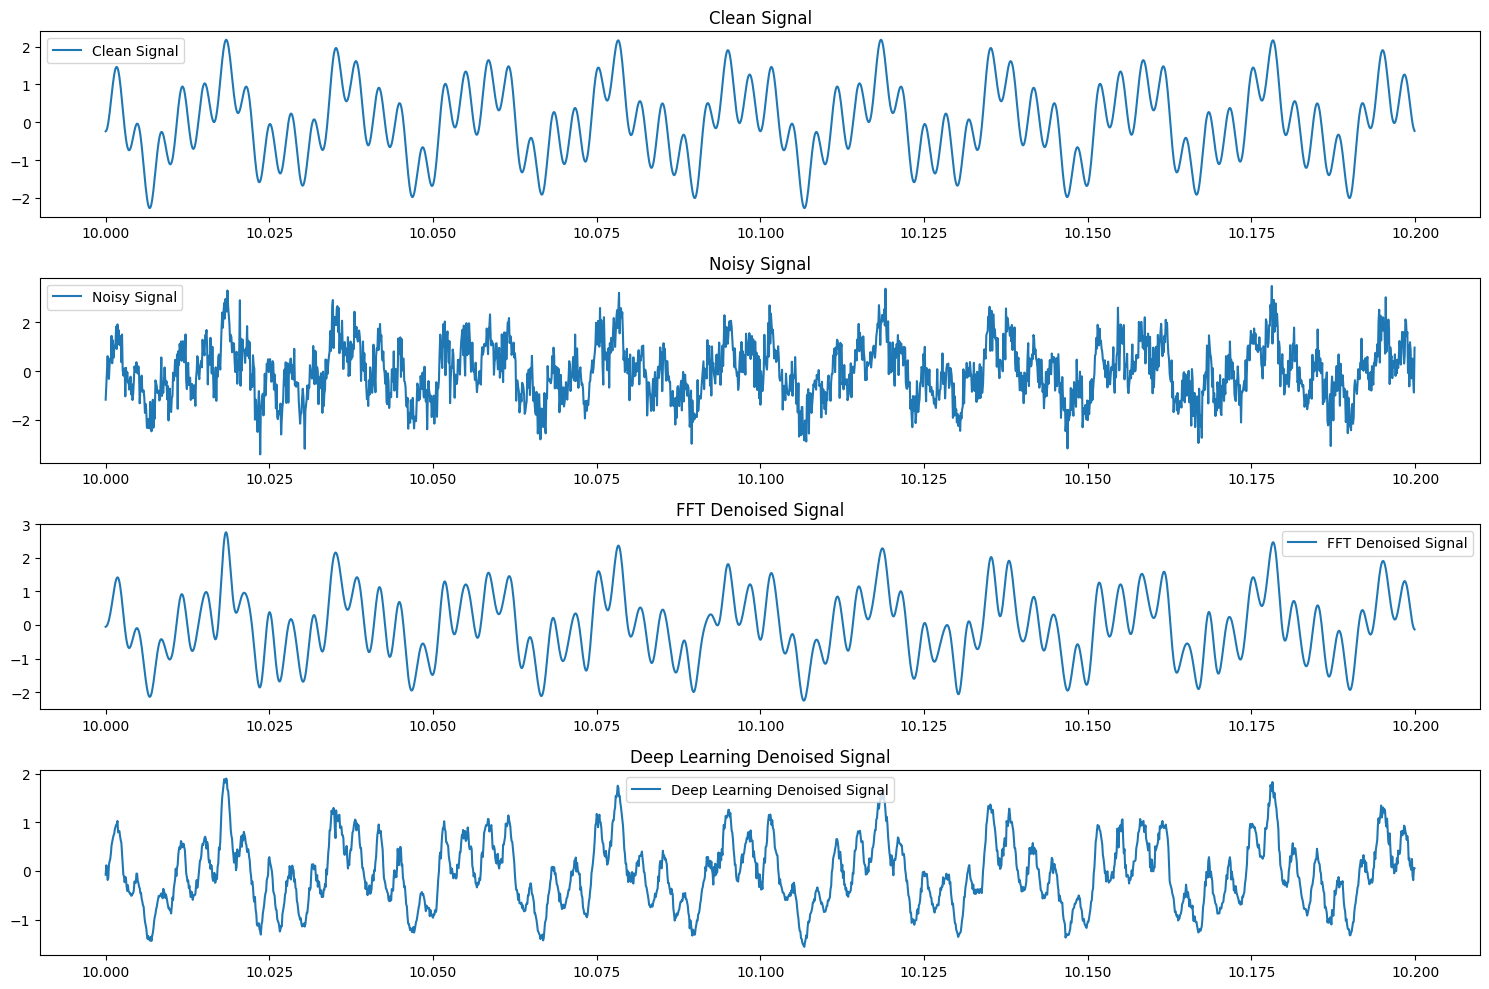

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from time import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Generation
# ------------------

# Parameters
fs = 10000  # Sampling frequency
T = 50      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N)

# Signal parameters
A = [1.0, 0.5, 0.8]                    # Amplitudes
f_sinusoids = [50, 120, 300]           # Frequencies
phi = np.random.uniform(0, 2*np.pi, 3)  # Phase shifts

# Generate clean signal
s = np.zeros(N)
for k in range(3):
    s += A[k] * np.sin(2 * np.pi * f_sinusoids[k] * t + phi[k])

# Add Gaussian white noise
SNR = 5  # Desired Signal-to-Noise Ratio in dB
signal_power = np.mean(s**2)
noise_power = signal_power / (10**(SNR / 10))
noise = np.random.normal(0, np.sqrt(noise_power), N)
y = s + noise  # Noisy signal

# 2. Fast Fourier Transform (FFT) Denoising
# -----------------------------------------

def fft_denoise(y, fs, cutoff_freq):
    # Compute FFT
    Y = fft(y)
    freqs = fftfreq(len(y), d=1/fs)

    # Create a low-pass filter
    filter_mask = np.abs(freqs) <= cutoff_freq
    Y_filtered = Y * filter_mask

    # Inverse FFT to get the denoised signal
    s_hat = np.real(ifft(Y_filtered))
    return s_hat

# Apply FFT denoising
cutoff_freq = 500  # Hz
start_time = time()
s_hat_fft = fft_denoise(y, fs, cutoff_freq)
fft_time = time() - start_time

# 3. Deep Learning Denoising
# --------------------------

# Prepare data for training
window_size = 1024  # Size of the sliding window
stride = 512        # Step size for the sliding window

def create_dataset(noisy_signal, clean_signal, window_size, stride):
    X = []
    Y = []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        Y.append(clean_signal[i:i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return X[..., np.newaxis], Y[..., np.newaxis]

# Create training and testing datasets
X, Y = create_dataset(y, s, window_size, stride)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Build the model
model = Sequential([
    Conv1D(16, kernel_size=9, padding='same', input_shape=(window_size, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(16, kernel_size=9, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(1, kernel_size=9, padding='same')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
start_time = time()
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))
training_time = time() - start_time

# Denoise the signal using the trained model
def deep_learning_denoise(model, noisy_signal, window_size, stride):
    s_hat = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for i in range(0, len(noisy_signal) - window_size, stride):
        input_segment = noisy_signal[i:i+window_size][np.newaxis, ..., np.newaxis]
        denoised_segment = model.predict(input_segment, verbose=0)[0, ..., 0]
        s_hat[i:i+window_size] += denoised_segment
        counts[i:i+window_size] += 1
    # Handle division by zero
    counts[counts == 0] = 1
    s_hat /= counts
    return s_hat

# Apply deep learning denoising
start_time = time()
s_hat_dl = deep_learning_denoise(model, y, window_size, stride)
dl_inference_time = time() - start_time

# 4. Performance Evaluation
# -------------------------

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal)**2)
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((clean_signal - denoised_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# Original noisy signal metrics
_, snr_noisy = compute_metrics(s, y)

# FFT metrics
mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
delta_snr_fft = snr_fft - snr_noisy

# Deep Learning metrics
mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
delta_snr_dl = snr_dl - snr_noisy

# Print results
print("Performance Metrics:")
print(f"FFT Denoising - MSE: {mse_fft:.6f}, ΔSNR: {delta_snr_fft:.2f} dB, Time: {fft_time:.2f} seconds")
print(f"Deep Learning Denoising - MSE: {mse_dl:.6f}, ΔSNR: {delta_snr_dl:.2f} dB, Inference Time: {dl_inference_time:.2f} seconds, Training Time: {training_time:.2f} seconds")

# 5. Visualization
# ----------------

# Plot a segment of the signals for comparison
start_plot = 100000  # Adjusted for better visualization in a large dataset
end_plot = start_plot + 2000

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(t[start_plot:end_plot], s[start_plot:end_plot], label='Clean Signal')
plt.title('Clean Signal')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t[start_plot:end_plot], y[start_plot:end_plot], label='Noisy Signal')
plt.title('Noisy Signal')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t[start_plot:end_plot], s_hat_fft[start_plot:end_plot], label='FFT Denoised Signal')
plt.title('FFT Denoised Signal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t[start_plot:end_plot], s_hat_dl[start_plot:end_plot], label='Deep Learning Denoised Signal')
plt.title('Deep Learning Denoised Signal')
plt.legend()

plt.tight_layout()
plt.show()


Processing for SNR = 0 dB
Processing for SNR = 2 dB
Processing for SNR = 4 dB
Processing for SNR = 6 dB
Processing for SNR = 8 dB
Processing for SNR = 10 dB
Processing for SNR = 12 dB
Processing for SNR = 14 dB
Processing for SNR = 16 dB
Processing for SNR = 18 dB
Processing for SNR = 20 dB


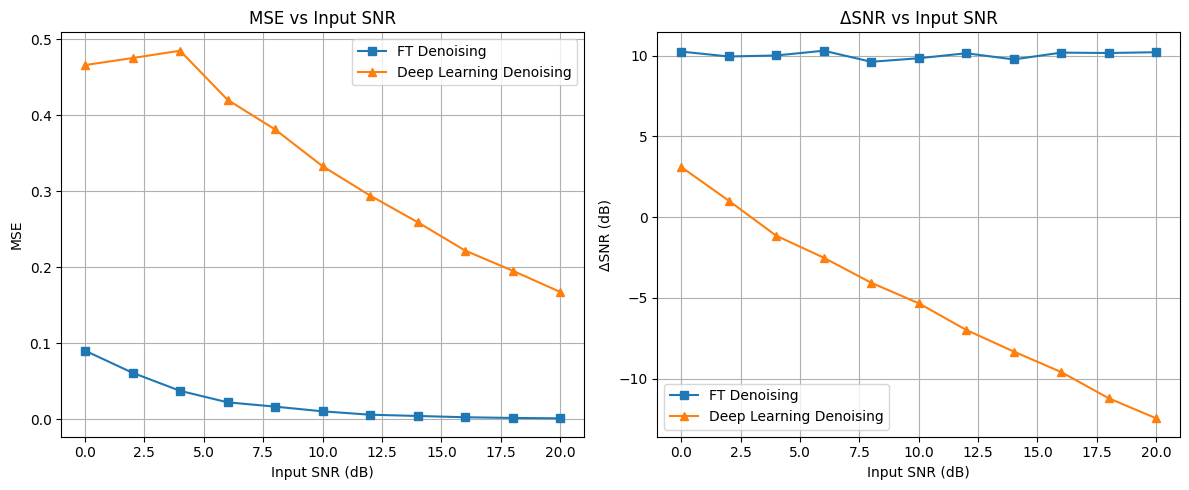

In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from time import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Generation
# ------------------

# Parameters
fs = 10000  # Sampling frequency
T = 1       # Duration in seconds (reduced for computational efficiency)
N = fs * T  # Total number of samples
t = np.linspace(0, T, N)

# Signal parameters
A = [1.0, 0.5, 0.8]                    # Amplitudes
f_sinusoids = [50, 120, 300]           # Frequencies
phi = np.random.uniform(0, 2*np.pi, 3)  # Phase shifts

# Generate clean signal
def generate_clean_signal(t, A, f_sinusoids, phi):
    s = np.zeros(len(t))
    for k in range(3):
        s += A[k] * np.sin(2 * np.pi * f_sinusoids[k] * t + phi[k])
    return s

# 2. Denoising Methods
# --------------------

# Fast Fourier Transform (FFT) Denoising
def fft_denoise(y, fs, cutoff_freq):
    # Compute FFT
    Y = fft(y)
    freqs = fftfreq(len(y), d=1/fs)

    # Create a low-pass filter
    filter_mask = np.abs(freqs) <= cutoff_freq
    Y_filtered = Y * filter_mask

    # Inverse FFT to get the denoised signal
    s_hat = np.real(ifft(Y_filtered))
    return s_hat

# Deep Learning Denoising
def create_dataset(noisy_signal, clean_signal, window_size, stride):
    X = []
    Y = []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        Y.append(clean_signal[i:i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return X[..., np.newaxis], Y[..., np.newaxis]

def build_denoising_model(window_size):
    model = Sequential([
        Conv1D(16, kernel_size=9, padding='same', input_shape=(window_size, 1)),
        BatchNormalization(),
        Activation('relu'),
        Conv1D(16, kernel_size=9, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv1D(1, kernel_size=9, padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def deep_learning_denoise(model, noisy_signal, window_size, stride):
    s_hat = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for i in range(0, len(noisy_signal) - window_size, stride):
        input_segment = noisy_signal[i:i+window_size][np.newaxis, ..., np.newaxis]
        denoised_segment = model.predict(input_segment, verbose=0)[0, ..., 0]
        s_hat[i:i+window_size] += denoised_segment
        counts[i:i+window_size] += 1
    # Handle division by zero
    counts[counts == 0] = 1
    s_hat /= counts
    return s_hat

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal)**2)
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((clean_signal - denoised_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# 3. Accuracy Comparison
# ----------------------

# SNR levels to test
SNR_levels = np.arange(0, 21, 2)  # From 0 dB to 20 dB in steps of 2 dB

# Initialize lists to store results
mse_fft_list = []
delta_snr_fft_list = []
mse_dl_list = []
delta_snr_dl_list = []

# Denoising parameters
cutoff_freq = 500  # Hz
window_size = 256  # Window size for smaller dataset
stride = 128

# Build the deep learning model once
model = build_denoising_model(window_size)

for SNR in SNR_levels:
    print(f"Processing for SNR = {SNR} dB")

    # Generate clean signal
    s = generate_clean_signal(t, A, f_sinusoids, phi)

    # Add Gaussian white noise
    signal_power = np.mean(s**2)
    noise_power = signal_power / (10**(SNR / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), N)
    y = s + noise  # Noisy signal

    # Compute SNR of noisy signal
    _, snr_noisy = compute_metrics(s, y)

    # FFT Denoising
    start_time = time()
    s_hat_fft = fft_denoise(y, fs, cutoff_freq)
    fft_time = time() - start_time
    mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
    delta_snr_fft = snr_fft - snr_noisy
    mse_fft_list.append(mse_fft)
    delta_snr_fft_list.append(delta_snr_fft)

    # Deep Learning Denoising
    # Prepare data for training
    X_train, Y_train = create_dataset(y, s, window_size, stride)
    # Train the model
    model.fit(X_train, Y_train, epochs=5, batch_size=32, verbose=0)
    # Denoise the signal
    start_time = time()
    s_hat_dl = deep_learning_denoise(model, y, window_size, stride)
    dl_time = time() - start_time
    mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
    delta_snr_dl = snr_dl - snr_noisy
    mse_dl_list.append(mse_dl)
    delta_snr_dl_list.append(delta_snr_dl)

# 4. Plotting the Results
# -----------------------

plt.figure(figsize=(12, 5))

# Plot MSE vs SNR
plt.subplot(1, 2, 1)
plt.plot(SNR_levels, mse_fft_list, 's-', label='FT Denoising')
plt.plot(SNR_levels, mse_dl_list, '^-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('MSE')
plt.title('MSE vs Input SNR')
plt.legend()
plt.grid(True)

# Plot ΔSNR vs SNR
plt.subplot(1, 2, 2)
plt.plot(SNR_levels, delta_snr_fft_list, 's-', label='FT Denoising')
plt.plot(SNR_levels, delta_snr_dl_list, '^-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('ΔSNR (dB)')
plt.title('ΔSNR vs Input SNR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.8299 - val_loss: 0.4531
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0922 - val_loss: 0.3475
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0566 - val_loss: 0.2498
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0482 - val_loss: 0.1812
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0443 - val_loss: 0.1291

Performance Metrics:
FT Denoising - MSE: 0.030180, ΔSNR: 9.96 dB, Time: 0.04 seconds
Deep Learning Denoising - MSE: 0.129170, ΔSNR: 3.65 dB, Inference Time: 68.08 seconds, Training Time: 12.80 seconds


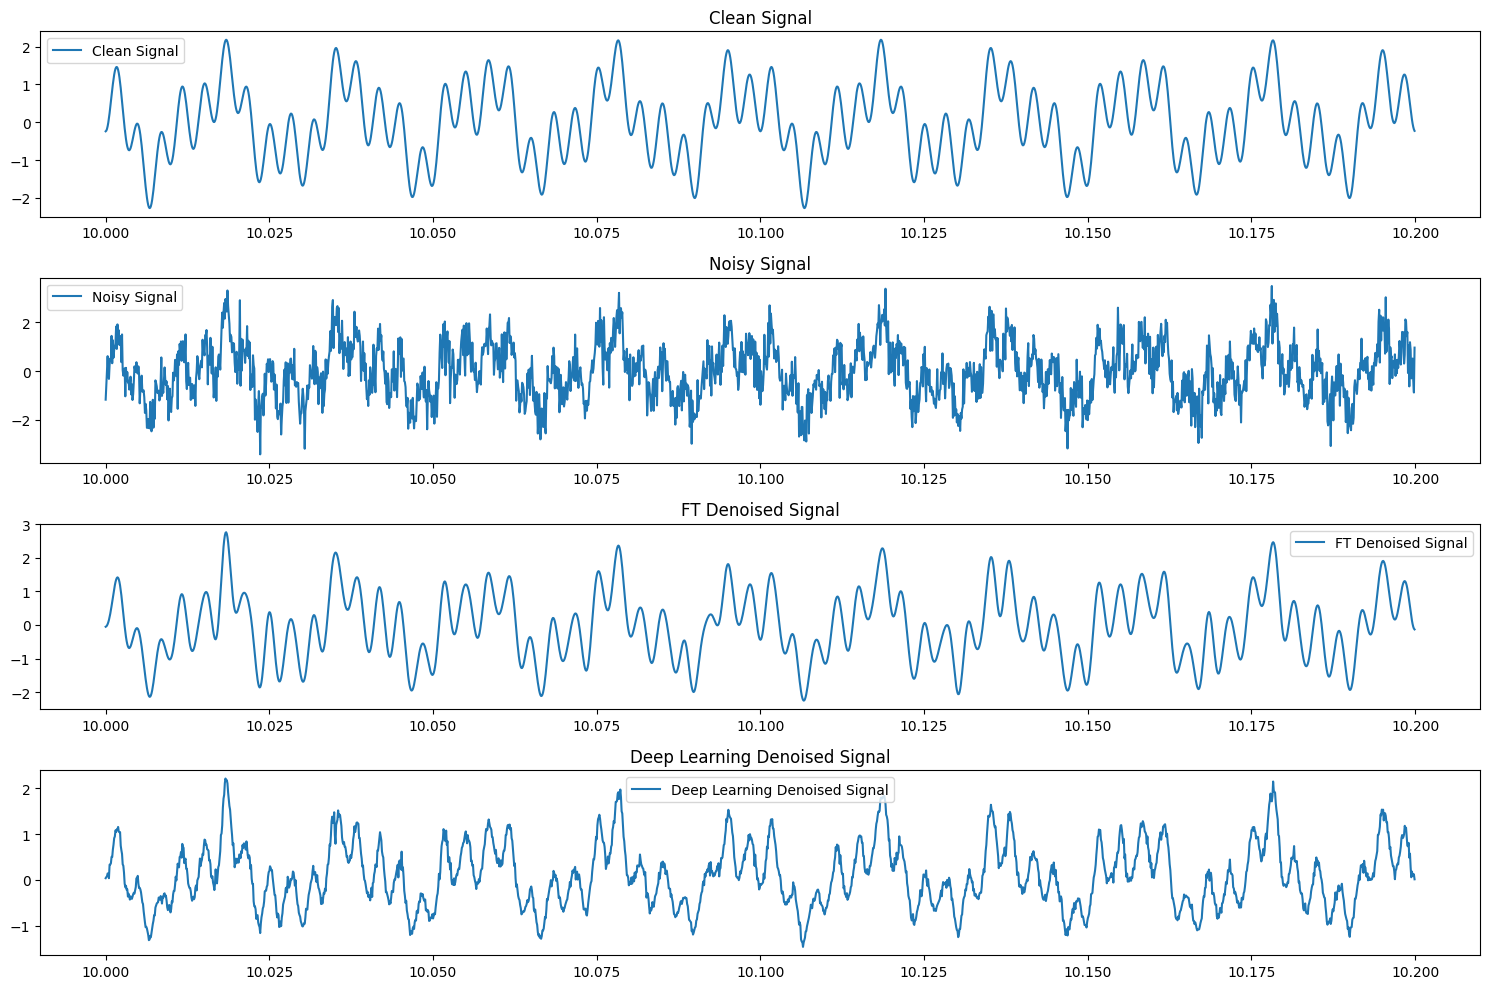

In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from time import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Generation
# ------------------

# Parameters
fs = 10000  # Sampling frequency
T = 50      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N)

# Signal parameters
A = [1.0, 0.5, 0.8]                    # Amplitudes
f_sinusoids = [50, 120, 300]           # Frequencies
phi = np.random.uniform(0, 2*np.pi, 3)  # Phase shifts

# Generate clean signal
s = np.zeros(N)
for k in range(3):
    s += A[k] * np.sin(2 * np.pi * f_sinusoids[k] * t + phi[k])

# Add Gaussian white noise
SNR = 5  # Desired Signal-to-Noise Ratio in dB
signal_power = np.mean(s**2)
noise_power = signal_power / (10**(SNR / 10))
noise = np.random.normal(0, np.sqrt(noise_power), N)
y = s + noise  # Noisy signal

# 2. Fourier Transform (FT) Denoising
# ------------------------------------

def fft_denoise(y, fs, cutoff_freq):
    # Compute FFT
    Y = fft(y)
    freqs = fftfreq(len(y), d=1/fs)

    # Create a low-pass filter
    filter_mask = np.abs(freqs) <= cutoff_freq
    Y_filtered = Y * filter_mask

    # Inverse FFT to get the denoised signal
    s_hat = np.real(ifft(Y_filtered))
    return s_hat

# Apply FT denoising and measure runtime
cutoff_freq = 500  # Hz
start_time = time()
s_hat_fft = fft_denoise(y, fs, cutoff_freq)
fft_time = time() - start_time

# 3. Deep Learning Denoising
# --------------------------

# Prepare data for training
window_size = 1024  # Size of the sliding window
stride = 512        # Step size for the sliding window

def create_dataset(noisy_signal, clean_signal, window_size, stride):
    X = []
    Y = []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        Y.append(clean_signal[i:i+window_size])
    X = np.array(X)
    Y = np.array(Y)
    return X[..., np.newaxis], Y[..., np.newaxis]

# Create training and testing datasets
X, Y = create_dataset(y, s, window_size, stride)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Build the model
model = Sequential([
    Conv1D(16, kernel_size=9, padding='same', input_shape=(window_size, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(16, kernel_size=9, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(1, kernel_size=9, padding='same')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model and measure training time
start_time = time()
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))
training_time = time() - start_time

# Denoise the signal using the trained model and measure inference time
def deep_learning_denoise(model, noisy_signal, window_size, stride):
    s_hat = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for i in range(0, len(noisy_signal) - window_size, stride):
        input_segment = noisy_signal[i:i+window_size][np.newaxis, ..., np.newaxis]
        denoised_segment = model.predict(input_segment, verbose=0)[0, ..., 0]
        s_hat[i:i+window_size] += denoised_segment
        counts[i:i+window_size] += 1
    # Handle division by zero
    counts[counts == 0] = 1
    s_hat /= counts
    return s_hat

start_time = time()
s_hat_dl = deep_learning_denoise(model, y, window_size, stride)
dl_inference_time = time() - start_time

# 4. Performance Evaluation
# -------------------------

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal)**2)
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean((clean_signal - denoised_signal)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# Original noisy signal metrics
_, snr_noisy = compute_metrics(s, y)

# FT metrics
mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
delta_snr_fft = snr_fft - snr_noisy

# Deep Learning metrics
mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
delta_snr_dl = snr_dl - snr_noisy

# Print results
print("\nPerformance Metrics:")
print(f"FT Denoising - MSE: {mse_fft:.6f}, ΔSNR: {delta_snr_fft:.2f} dB, Time: {fft_time:.2f} seconds")
print(f"Deep Learning Denoising - MSE: {mse_dl:.6f}, ΔSNR: {delta_snr_dl:.2f} dB, Inference Time: {dl_inference_time:.2f} seconds, Training Time: {training_time:.2f} seconds")

# 5. Visualization
# ----------------

# Plot a segment of the signals for comparison
start_plot = 100000  # Adjusted for better visualization in a large dataset
end_plot = start_plot + 2000

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(t[start_plot:end_plot], s[start_plot:end_plot], label='Clean Signal')
plt.title('Clean Signal')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t[start_plot:end_plot], y[start_plot:end_plot], label='Noisy Signal')
plt.title('Noisy Signal')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t[start_plot:end_plot], s_hat_fft[start_plot:end_plot], label='FT Denoised Signal')
plt.title('FT Denoised Signal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t[start_plot:end_plot], s_hat_dl[start_plot:end_plot], label='Deep Learning Denoised Signal')
plt.title('Deep Learning Denoised Signal')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# 4. Performance Evaluation
# -------------------------

# Function to compute MSE and SNR
def compute_metrics(clean_signal, denoised_signal):
    mse = np.mean((clean_signal - denoised_signal) ** 2)
    signal_power = np.mean(clean_signal ** 2)
    noise_power = np.mean((clean_signal - denoised_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return mse, snr

# Compute SNR of the original noisy signal
_, snr_noisy = compute_metrics(s, y)

# Compute metrics for FT denoising
mse_fft, snr_fft = compute_metrics(s, s_hat_fft)
delta_snr_fft = snr_fft - snr_noisy

# Compute metrics for Deep Learning denoising
mse_dl, snr_dl = compute_metrics(s, s_hat_dl)
delta_snr_dl = snr_dl - snr_noisy

# Print performance metrics
print("\nPerformance Metrics:")
print(f"FT Denoising - MSE: {mse_fft:.6f}, ΔSNR: {delta_snr_fft:.2f} dB")
print(f"Deep Learning Denoising - MSE: {mse_dl:.6f}, ΔSNR: {delta_snr_dl:.2f} dB")



Performance Metrics:
FT Denoising - MSE: 0.030180, ΔSNR: 9.96 dB
Deep Learning Denoising - MSE: 0.129170, ΔSNR: 3.65 dB


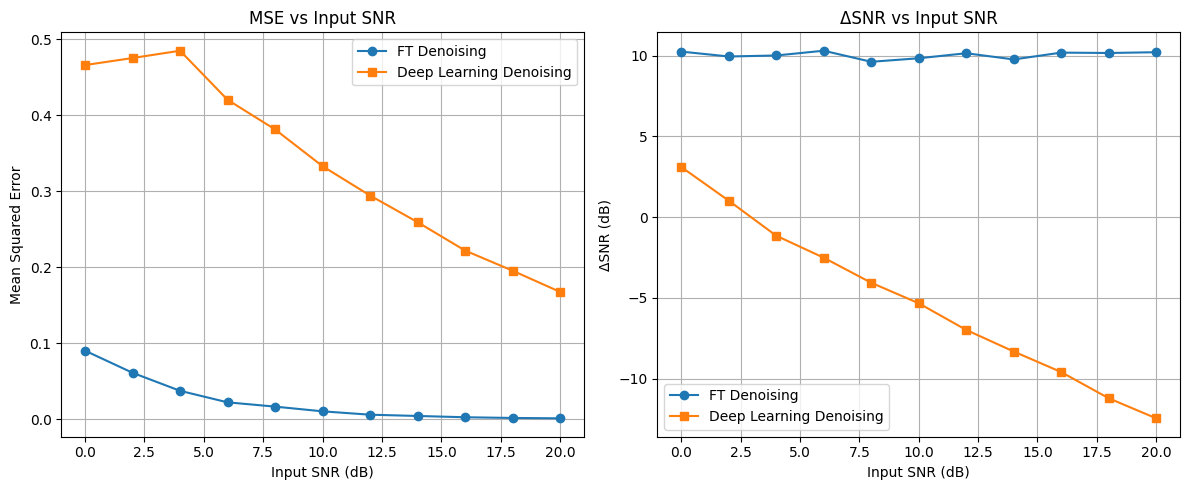

In [12]:
# Assuming you have lists of MSE and ΔSNR values for different SNR levels
# SNR_levels = [...]  # List of SNR levels
# mse_fft_list = [...]  # List of MSE values for FT denoising
# mse_dl_list = [...]  # List of MSE values for Deep Learning denoising
# delta_snr_fft_list = [...]  # List of ΔSNR values for FT denoising
# delta_snr_dl_list = [...]  # List of ΔSNR values for Deep Learning denoising

plt.figure(figsize=(12, 5))

# Plot MSE vs Input SNR
plt.subplot(1, 2, 1)
plt.plot(SNR_levels, mse_fft_list, 'o-', label='FT Denoising')
plt.plot(SNR_levels, mse_dl_list, 's-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Input SNR')
plt.legend()
plt.grid(True)

# Plot ΔSNR vs Input SNR
plt.subplot(1, 2, 2)
plt.plot(SNR_levels, delta_snr_fft_list, 'o-', label='FT Denoising')
plt.plot(SNR_levels, delta_snr_dl_list, 's-', label='Deep Learning Denoising')
plt.xlabel('Input SNR (dB)')
plt.ylabel('ΔSNR (dB)')
plt.title('ΔSNR vs Input SNR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


ERROR: unknown command "pylatex"
